# Zadanie - predykcja profesji osoby na podstawie jej życiorysu

In [69]:
!pip install -U datasets

In [70]:
from datasets import load_dataset
import pandas as pd
import plotly.express as px
import re

## Zebranie i przygotowanie danych

### Wczytanie danych

In [71]:
dataset = load_dataset("LabHC/bias_in_bios")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['hard_text', 'profession', 'gender'],
        num_rows: 257478
    })
    test: Dataset({
        features: ['hard_text', 'profession', 'gender'],
        num_rows: 99069
    })
    dev: Dataset({
        features: ['hard_text', 'profession', 'gender'],
        num_rows: 39642
    })
})


Podział danych na zbiór treningowy i testowy został już wykonany, w związku z czym nie musimy ręcznie dzielić danych.

In [72]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()
# Wypisanie danych wejściowych
train_df.head()

hard_text  profession  gender
0  He is also the project lead of and major contr...          21       0
1  She is able to assess, diagnose and treat mino...          13       1
2  Prior to law school, Brittni graduated magna c...           2       1
3  He regularly contributes to India’s First Onli...          11       0
4  He completed his medical degree at Northwester...          21       0

In [73]:
train_df.sample(4)

hard_text  profession  gender
223763  Ms. Crosby practices medicine in Augusta, GA a...          19       1
122053  She graduated with honors in 2010. Having more...          13       1
137754  Her areas of expertise include adoption issues...          22       1
148916  She received her B.A. at Yale University and P...          21       1

In [74]:
# Sprawdzenie rozkładu atrybutu decyzyjnego
train_professions = train_df.groupby('profession').nunique()
test_professions = test_df.groupby('profession').nunique()

fig = px.bar(train_professions, y="hard_text", title="Rozkład profesji w danych treningowych")
fig.update_layout(xaxis={'dtick':1})
fig.show()
fig = px.bar(test_professions, y="hard_text", title="Rozkład profesji w danych testowych")
fig.update_layout(xaxis={'dtick':1})
fig.show()

W obu zbiorach danych rozkład wartości jest przybliżony. Klasy nie są równomiernie rozłożone - wyraźnie dominuje klasa 21 (profesor). Jest to zgodne z informacjami na huggingface, gdzie jest napisane, że ta klasa stanowi 29,8% przypadków.

### Preprocessing

Usunięcie duplikatów

In [75]:
train_df.groupby('profession').nunique()

hard_text  gender
profession                   
0                3655       2
1                6554       2
2               21122       2
3                1707       2
4                1820       2
5                3634       2
6                9453       2
7                2563       2
8                 964       2
9                4541       2
10                947       2
11              12929       2
12               4862       2
13              12308       2
14               5021       2
15               1145       2
16               1636       2
17                927       2
18              15752       2
19              26620       2
20               4556       2
21              76660       2
22              11936       2
23                911       2
24               4483       2
25               8820       2
26              10517       2
27               1073       2

In [76]:
train_df.drop_duplicates(subset=['hard_text'], inplace=True)
train_df.groupby('profession').nunique()

hard_text  gender
profession                   
0                3655       2
1                6553       2
2               21122       2
3                1700       2
4                1820       2
5                3634       2
6                9451       2
7                2563       2
8                 964       2
9                4541       2
10                947       2
11              12929       2
12               4862       2
13              12307       2
14               5021       2
15               1145       2
16               1636       2
17                927       2
18              15752       2
19              26616       2
20               4556       2
21              76659       2
22              11934       2
23                911       2
24               4483       2
25               8818       2
26              10517       2
27               1073       2

In [77]:
test_df.groupby('profession').nunique()

hard_text  gender
profession                   
0                1409       2
1                2527       2
2                8135       2
3                 662       2
4                 703       2
5                1400       2
6                3633       2
7                 989       2
8                 372       2
9                1749       2
10                366       2
11               4982       2
12               1874       2
13               4734       2
14               1935       2
15                442       2
16                632       2
17                358       2
18               6067       2
19              10247       2
20               1754       2
21              29509       2
22               4594       2
23                351       2
24               1724       2
25               3396       2
26               4050       2
27                416       2

In [78]:
test_df.drop_duplicates(subset=['hard_text'], inplace=True)
test_df.groupby('profession').nunique()

hard_text  gender
profession                   
0                1409       2
1                2527       2
2                8135       2
3                 658       2
4                 703       2
5                1400       2
6                3632       2
7                 989       2
8                 372       2
9                1749       2
10                366       2
11               4982       2
12               1874       2
13               4734       2
14               1935       2
15                442       2
16                632       2
17                358       2
18               6067       2
19              10245       2
20               1754       2
21              29509       2
22               4594       2
23                351       2
24               1724       2
25               3395       2
26               4050       2
27                416       2

In [79]:
# Zamiana na małe litery
train_df['hard_text'] = train_df['hard_text'].apply(lambda x: x.lower())
test_df['hard_text'] = test_df['hard_text'].apply(lambda x: x.lower())

In [80]:
# Usunięcie linków
url_re = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
train_df['hard_text'] = train_df['hard_text'].apply(lambda x: url_re.sub('', x))
test_df['hard_text'] = test_df['hard_text'].apply(lambda x: url_re.sub('', x))

In [81]:
# Usunięcie znaków interpunkcyjnych (oprócz apostrofu)
character_re = re.compile(r"[^a-z\s']")
train_df['hard_text'] = train_df['hard_text'].apply(lambda x: character_re.sub('', x))
test_df['hard_text'] = test_df['hard_text'].apply(lambda x: character_re.sub('', x))

train_df.head()

hard_text  profession  gender
0  he is also the project lead of and major contr...          21       0
1  she is able to assess diagnose and treat minor...          13       1
2  prior to law school brittni graduated magna cu...           2       1
3  he regularly contributes to indias first onlin...          11       0
4  he completed his medical degree at northwester...          21       0

In [82]:
!pip install contractions

Rozwijanie skrótów - w tym celu wykorzystuję bibliotekę [contractions](https://pypi.org/project/pycontractions/)

In [83]:
import contractions
def expand_abbreviations(text):
  expanded_words = []
  for word in text.split():
    expanded_words.append(contractions.fix(word))
  return ' '.join(expanded_words)
train_df['hard_text'] = train_df['hard_text'].apply(expand_abbreviations)
test_df['hard_text'] = test_df['hard_text'].apply(expand_abbreviations)

Usuwanie stop words przy pomocy spacy:

In [84]:
!echo "numpy<2.0" > constraints.txt

In [ ]:
# !pip install -U spacy --constraint constraints.txt
# !python -m spacy download en_core_web_md

In [85]:
!pip install spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [86]:
import spacy

In [87]:
nlp = spacy.load("en_core_web_md", disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu



In [88]:
def remove_stopwords(text):
    return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

train_df['hard_text'] = train_df['hard_text'].apply(remove_stopwords)
test_df['hard_text'] = test_df['hard_text'].apply(remove_stopwords)

In [89]:
train_df.head()

hard_text  profession  gender
0  project lead major contributor open source ass...          21       0
1  able assess diagnose treat minor illness condi...          13       1
2  prior law school brittni graduated magna cum l...           2       1
3  regularly contributes indias online muslim new...          11       0
4  completed medical degree northwestern universi...          21       0

Poprawa pisowni:

In [90]:
!pip install autocorrect

In [ ]:
from autocorrect import Speller
spell = Speller(lang='en')

def fix_spelling(text):
  return spell(text)

train_df['hard_text'] = train_df['hard_text'].apply(fix_spelling)
test_df['hard_text'] = test_df['hard_text'].apply(fix_spelling)

KeyboardInterrupt: 

Lematyzacja:

In [ ]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

train_df['hard_text'] = train_df['hard_text'].apply(lemmatize)
test_df['hard_text'] = test_df['hard_text'].apply(lemmatize)

KeyboardInterrupt: 

In [91]:
train_df.head()

hard_text  profession  gender
0  project lead major contributor open source ass...          21       0
1  able assess diagnose treat minor illness condi...          13       1
2  prior law school brittni graduated magna cum l...           2       1
3  regularly contributes indias online muslim new...          11       0
4  completed medical degree northwestern universi...          21       0

Ponieważ lematyzacja długo trwa, zapisuję dane do pliku, by nie musieć jej powtarzać.

In [130]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [133]:
# Wczytanie plików po zapisie
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

hard_text  profession  gender
0  project lead major contributor open source ass...        21.0     0.0
1  able assess diagnose treat minor illness condi...        13.0     1.0
2  prior law school brittni graduate magna cum la...         2.0     1.0
3  regularly contribute india online muslim newsp...        11.0     0.0
4  complete medical degree northwestern universit...        21.0     0.0

In [ ]:
# WordCloud - dla 3 najpopularniejszych klas
from wordcloud import WordCloud
most_popular_professions = train_df.groupby('profession').nunique().sort_values('hard_text', ascending=False).head(3)
print(f"Najbardziej popularne profesje: {most_popular_professions.index.values}")

Najbardziej popularne profesje: [21 19  2]


21


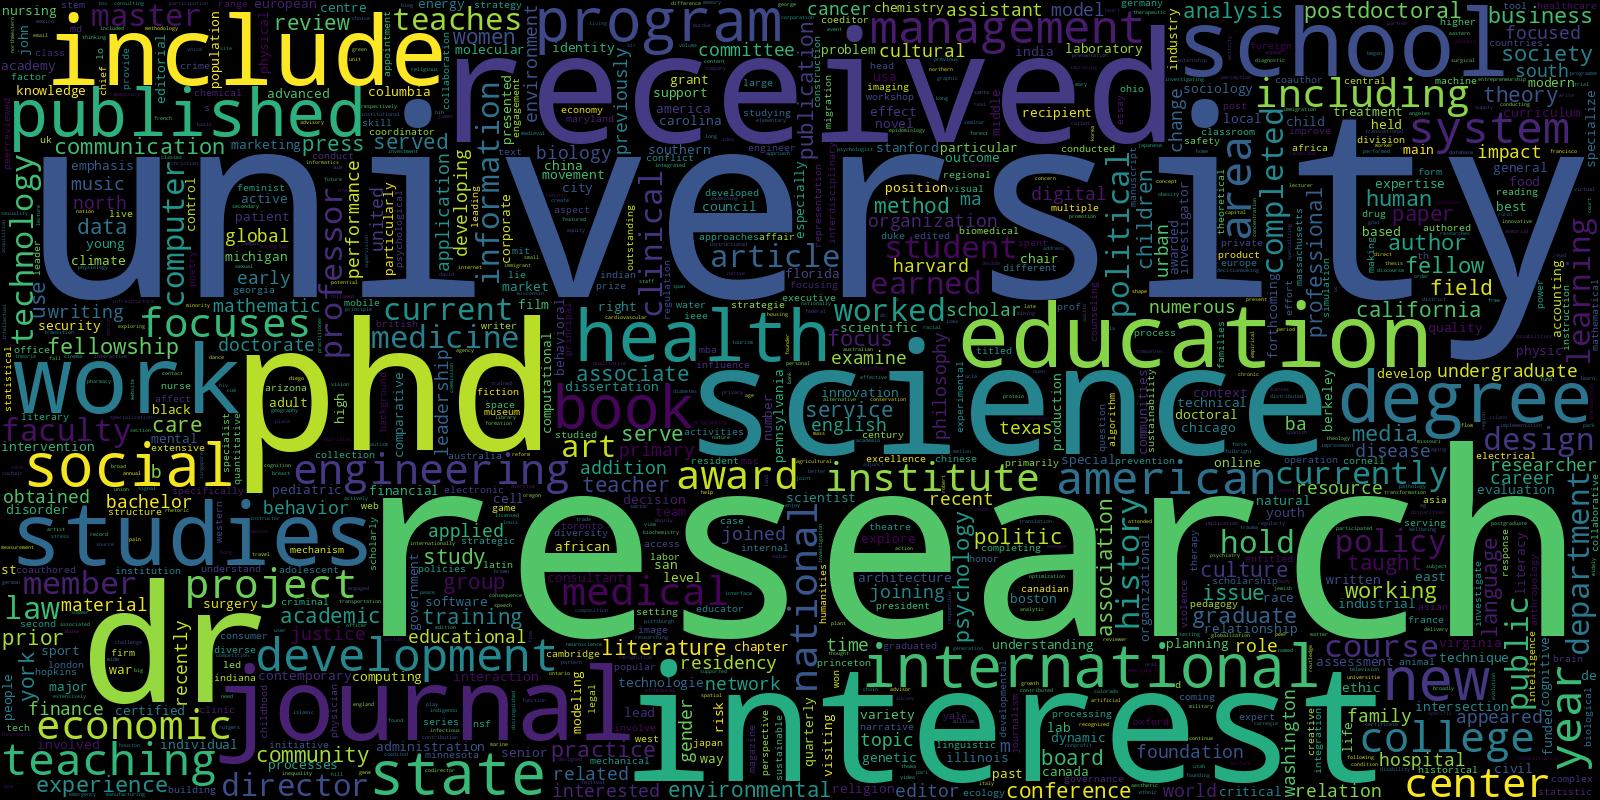

In [ ]:
print(most_popular_professions.index.values[0]) # 21 - profesor
text = ' '.join(train_df[train_df['profession']==most_popular_professions.index.values[0]]['hard_text'])
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(text)
wc.to_image()

19


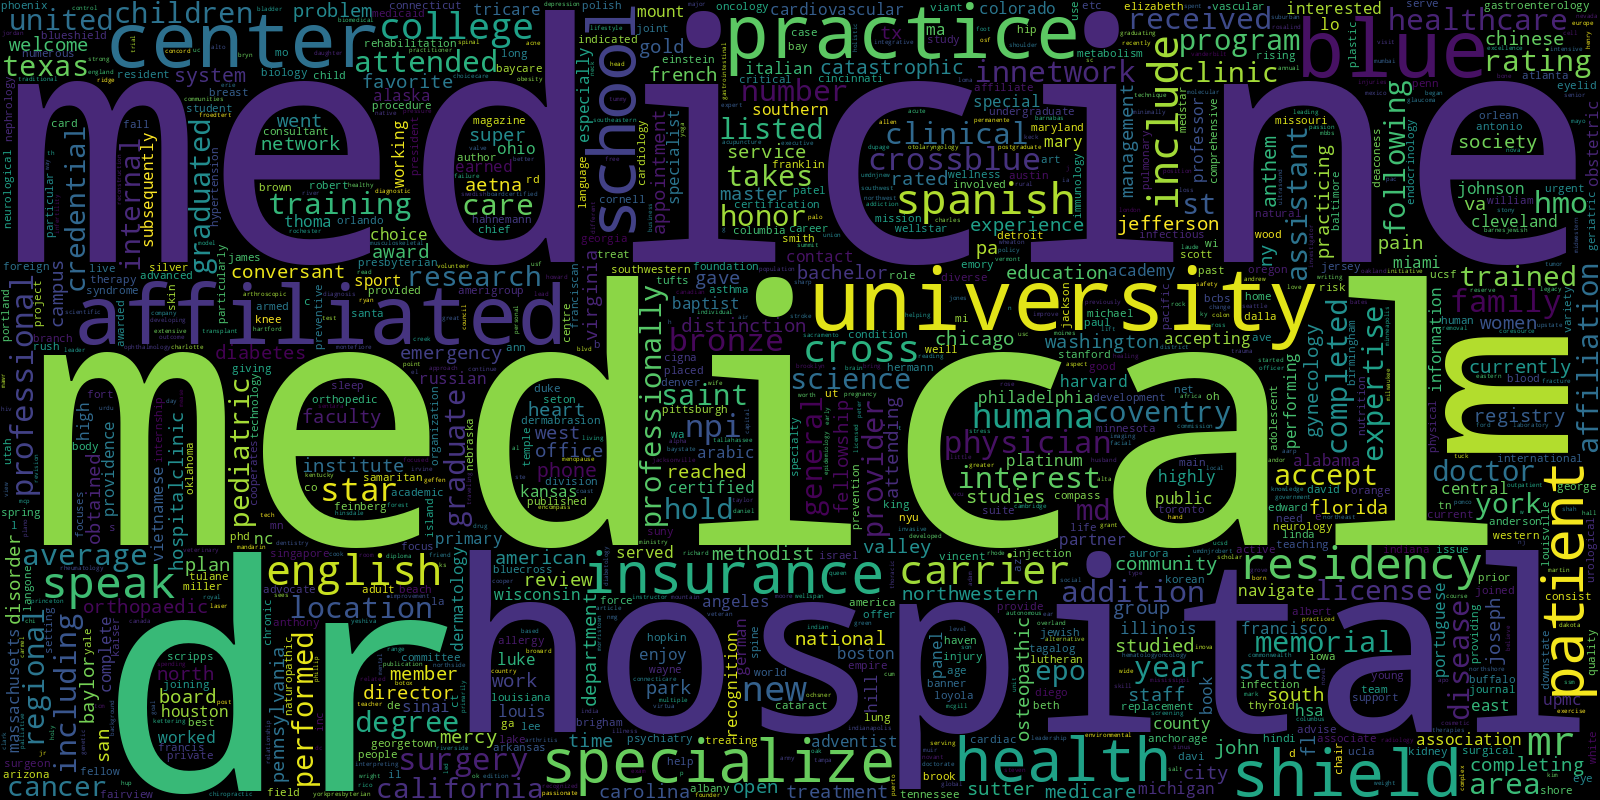

In [ ]:
print(most_popular_professions.index.values[1]) # 19 - lekarz (physician)
text = ' '.join(train_df[train_df['profession']==most_popular_professions.index.values[1]]['hard_text'])
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(text)
wc.to_image()

2


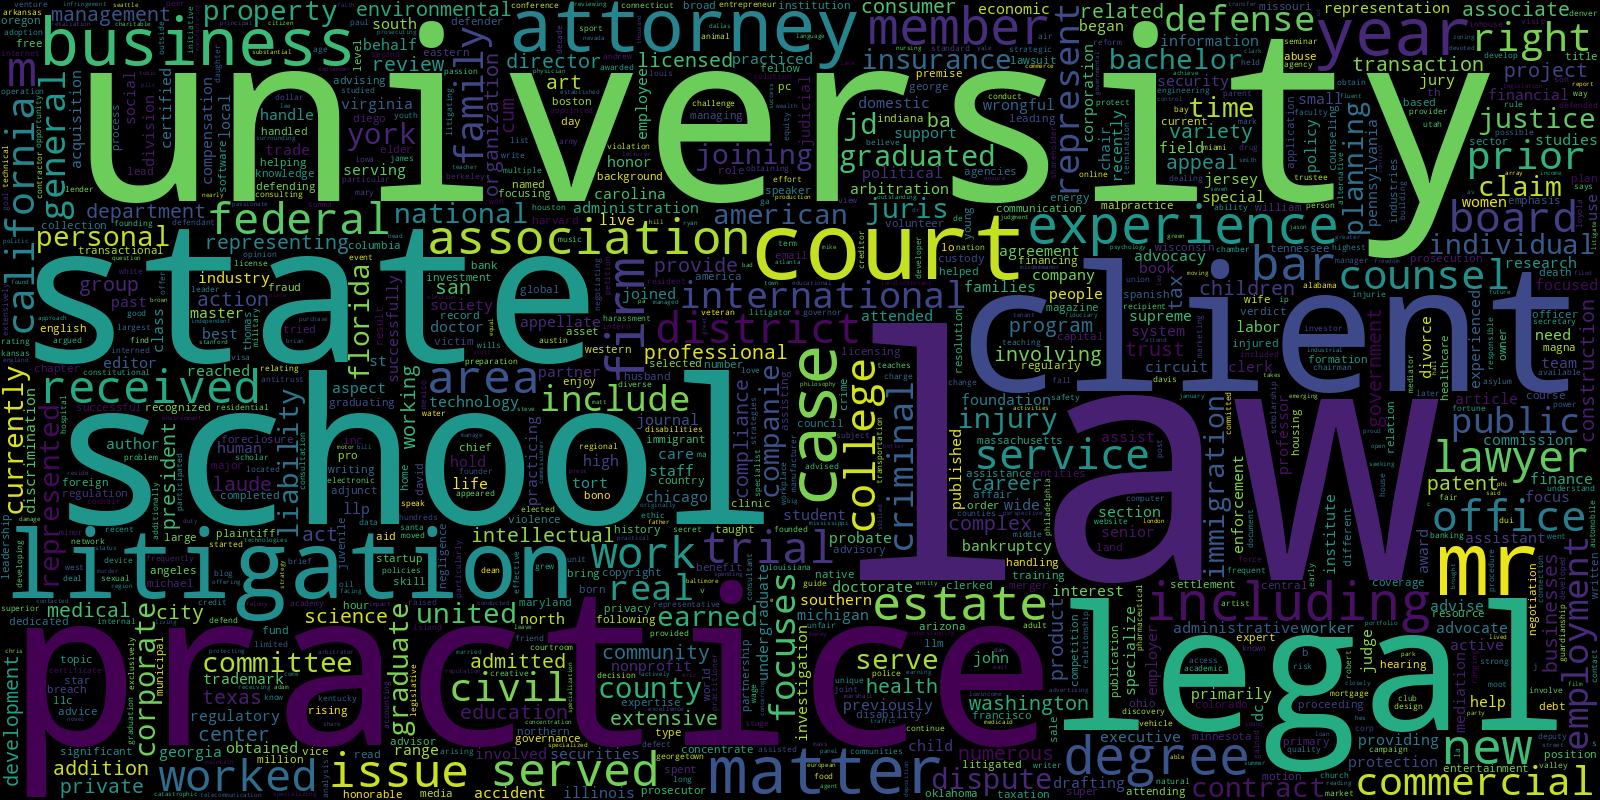

In [ ]:
print(most_popular_professions.index.values[2]) # 2 - prawnik (attorney)
text = ' '.join(train_df[train_df['profession']==most_popular_professions.index.values[2]]['hard_text'])
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(text)
wc.to_image()

Słownictwo wyraźnie pomaga rozróżnić te 3 przykładowe zawody - profesorowie uczelni często mają słowa "university" i "research" w swoich życiorysach, u lekarzy najpopularniejszymi słowami są "medicine" i "medical", a u prawników najpopularniejszym słowem jest "law".

## Inżynieria cech

In [94]:
train_df.isna().sum()

hard_text     0
profession    0
gender        0
dtype: int64

In [95]:
test_df.isna().sum()

hard_text     0
profession    0
gender        0
dtype: int64

Żaden ze zbiorów danych nie ma brakujących wartości.

In [134]:
unique_words = set()
for text in train_df['hard_text']:
    for word in text.split():
        unique_words.add(word)
num_unique_words = len(unique_words)

In [97]:
num_unique_words

297104

In [135]:
max_text_length = 0
for text in train_df['hard_text']:
   if len(text) > max_text_length:
    max_text_length = len(text)
max_text_length

762

In [136]:
# Tokenizacja
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=num_unique_words)
texts = train_df.hard_text.to_list()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index), end='\n\n')

train_data = pad_sequences(sequences, maxlen=max_text_length)
print(train_data)

# To samo dla zbioru testowego

texts = test_df.hard_text.to_list()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index), end='\n\n')

test_data = pad_sequences(sequences, maxlen=max_text_length)
print(test_data)

Found 165709 unique tokens

[[    0     0     0 ...   953   806 47743]
 [    0     0     0 ...   711   115 11748]
 [    0     0     0 ...   622   726  5725]
 ...
 [    0     0     0 ...  2808  1446    45]
 [    0     0     0 ...  1095    52  2083]
 [    0     0     0 ...   163  2878   525]]
Found 242799 unique tokens

[[    0     0     0 ...     3   249  1418]
 [    0     0     0 ...   521   386   159]
 [    0     0     0 ...  2456  7569 10055]
 ...
 [    0     0     0 ...   207 23192  3841]
 [    0     0     0 ...   384   313  3351]
 [    0     0     0 ...   464    13   580]]


Do przygotowania word embeddingu, wykorzystuję Glove.

In [100]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2025-01-06 17:14:23--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-06 17:14:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  4.99MB/s    in 2m 39s  

2025-01-06 17:17:02 (5.18 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]



In [101]:
from zipfile import ZipFile
with ZipFile('glove.6B.zip', 'r') as z:
  z.extractall()

In [137]:
import numpy as np
embeddings_index = dict()
f = open('./glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 400000 word vectors.


In [138]:
vocab = tokenizer.sequences_to_texts(texts)
vocab_size = len(tokenizer.word_index) + 1 # Dodajemy 1 bo indeks 0 jest już zarezerwowany
print(vocab_size)

# tworzymy macierz
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

242800


## Trenowanie modelu - klasyczne ML

**TODO: Dodać możliwość podania parametru płci do modelu**

In [139]:
from keras.models import Sequential, Model
from keras import layers
model = Sequential()
num_classes = 28

model.add(layers.Input(shape=(max_text_length,), dtype='int32', name='review_input'))
model.add(layers.Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], input_length=max_text_length, trainable=True))
model.add(layers.Flatten())
model.add(layers.Dense(units=200, activation='relu'))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=num_classes, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [140]:
X_train = train_data
y_train = pd.get_dummies(train_df['profession'], dtype=int).to_numpy()
X_test = test_data
y_test =  pd.get_dummies(test_df['profession'], dtype=int).to_numpy()

In [106]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [141]:
from tensorflow.config import run_functions_eagerly

# tf.config w celu uniknięcia ValueError: Creating variables on a non-first call to a function decorated with tf.function.
run_functions_eagerly(True)

history = model.fit(X_train,
          y_train,
          epochs=5,
          batch_size=1024,
          verbose=True,
          validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 32s 260ms/step - accuracy: 0.0782 - loss: 19.6238 - val_accuracy: 0.0992 - val_loss: 4.0692
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 258ms/step - accuracy: 0.3174 - loss: 3.2025 - val_accuracy: 0.3566 - val_loss: 2.4461
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - accuracy: 0.5313 - loss: 1.7947 - val_accuracy: 0.3483 - val_loss: 2.4797
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 31s 259ms/step - accuracy: 0.6485 - loss: 1.3154 - val_accuracy: 0.3353 - val_loss: 2.7008
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.7190 - loss: 1.0270 - val_accuracy: 0.3234 - val_loss: 2.9835


In [142]:
# ewaluacja

#dokladnosc na zbiorze testowym
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


3094/3094 ━━━━━━━━━━━━━━━━━━━━ 71s 23ms/step - accuracy: 0.3249 - loss: 2.9781
Test Loss: 2.9835269451141357
Test Accuracy: 0.32338741421699524


3094/3094 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step


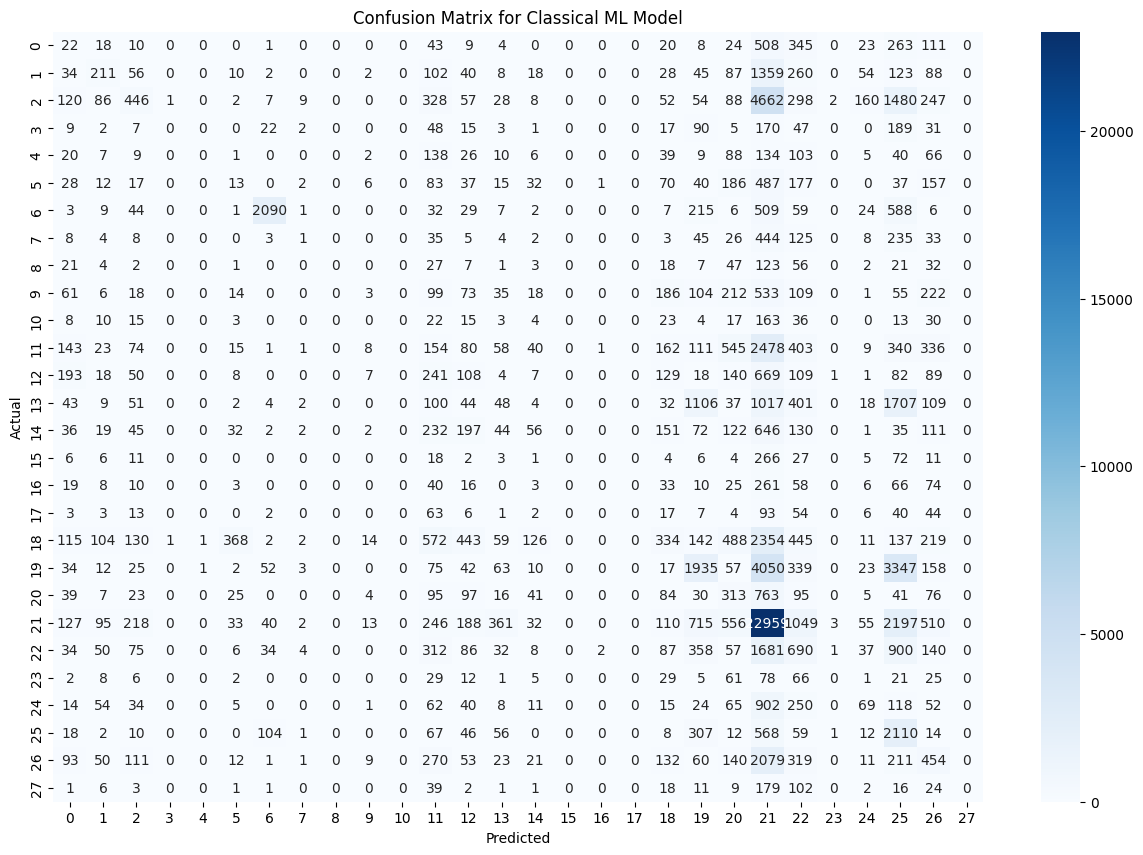

In [143]:
# macierz omylek
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predykcje dla zbioru testowego
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Generowanie macierzy pomyłek
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Classical ML Model')
plt.show()


In [144]:
from sklearn.metrics import classification_report

print("Classification Report for Classical ML Model:")
print(classification_report(y_true, y_pred))


Classification Report for Classical ML Model:
              precision    recall  f1-score   support

           0       0.02      0.02      0.02      1409
           1       0.25      0.08      0.13      2527
           2       0.29      0.05      0.09      8135
           3       0.00      0.00      0.00       658
           4       0.00      0.00      0.00       703
           5       0.02      0.01      0.01      1400
           6       0.88      0.58      0.70      3632
           7       0.03      0.00      0.00       989
           8       0.00      0.00      0.00       372
           9       0.04      0.00      0.00      1749
          10       0.00      0.00      0.00       366
          11       0.04      0.03      0.04      4982
          12       0.06      0.06      0.06      1874
          13       0.05      0.01      0.02      4734
          14       0.12      0.03      0.05      1935
          15       0.00      0.00      0.00       442
          16       0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Model oparty o Transformer

### Model BERT ze wstępnie wytrenowaną wersją z HuggingFace

In [ ]:
!pip install transformers

In [108]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
import numpy as np
from datasets import Dataset

In [109]:
def tokenize_function(examples):
    return tokenizer(examples['hard_text'], padding="max_length", truncation=True, max_length=128)

In [112]:
# Konfiguracja modelu
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer_model  = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=28)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [111]:
# Przygotowanie danych
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("profession", "labels")
test_dataset = test_dataset.rename_column("profession", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/257096 [00:00<?, ? examples/s]

Map:   0%|          | 0/99002 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00


In [122]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,  #na wiecej nie pozwolila mi pamiec
    gradient_accumulation_steps=8,  # symulowanie większego batch size
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    fp16=True,
    report_to=[]
)


trainer = Trainer(
    model=transformer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



TrainOutput(global_step=6024, training_loss=4.11911558756632, metrics={'train_runtime': 5454.2788, 'train_samples_per_second': 141.41, 'train_steps_per_second': 1.104, 'total_flos': 5.072386320310272e+16, 'train_loss': 4.11911558756632, 'epoch': 2.9986931358516395})

In [123]:
# Ewaluacja na zbiorze testowym
transformer_results = trainer.evaluate()
print(f"Transformer Model - Test Accuracy: {transformer_results['eval_accuracy']:.4f}")
print(f"Transformer Model - Test Loss: {transformer_results['eval_loss']:.4f}")

Transformer Model - Test Accuracy: 0.8530
Transformer Model - Test Loss: 0.4995


In [124]:
# Predykcje dla transformera
predictions = trainer.predict(test_dataset)
y_pred_transformer = np.argmax(predictions.predictions, axis=1)
y_true_transformer = test_dataset["labels"]


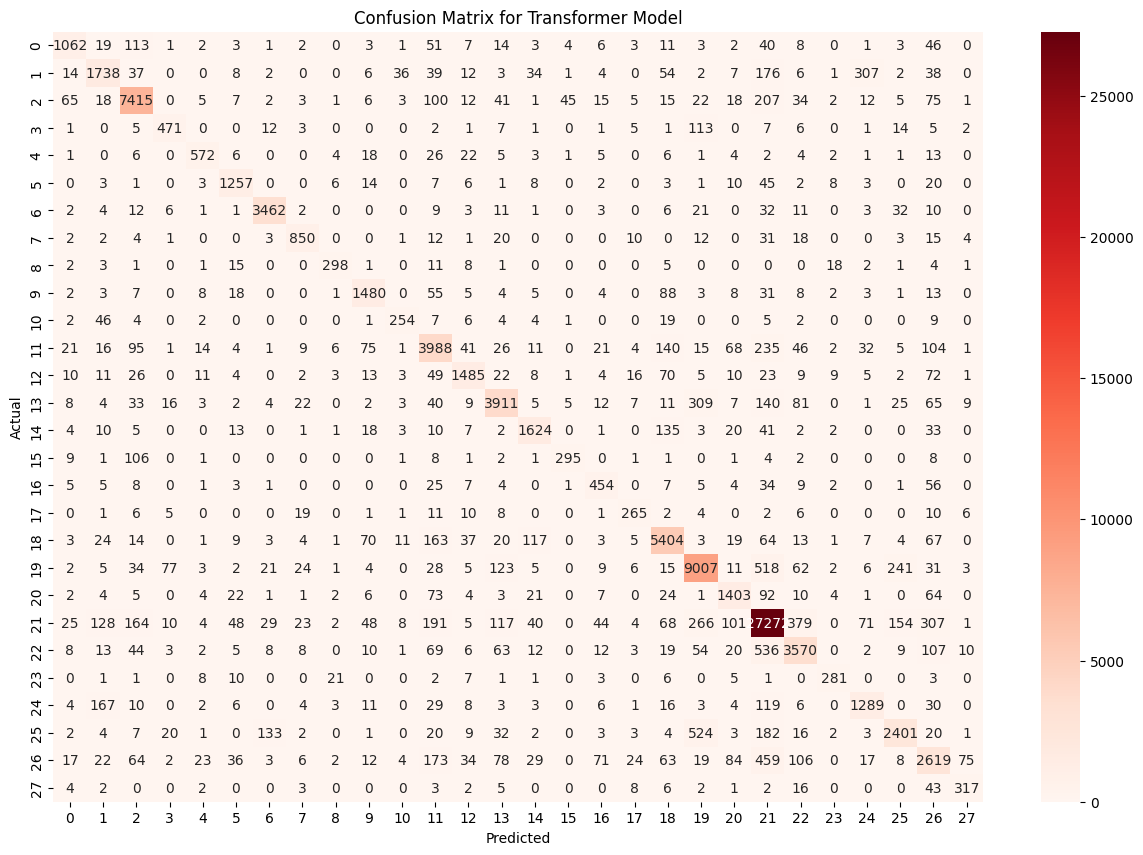

In [125]:
# Macierz pomyłek dla modelu Transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix_transformer = confusion_matrix(y_true_transformer, y_pred_transformer)

plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix_transformer, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Transformer Model')
plt.show()

In [126]:
# Raport klasyfikacji
from sklearn.metrics import classification_report
print("Classification Report for Transformer Model:")
print(classification_report(y_true_transformer, y_pred_transformer))

Classification Report for Transformer Model:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1409
           1       0.77      0.69      0.73      2527
           2       0.90      0.91      0.91      8135
           3       0.77      0.72      0.74       658
           4       0.85      0.81      0.83       703
           5       0.85      0.90      0.87      1400
           6       0.94      0.95      0.95      3632
           7       0.86      0.86      0.86       989
           8       0.85      0.80      0.82       372
           9       0.82      0.85      0.83      1749
          10       0.77      0.69      0.73       366
          11       0.77      0.80      0.78      4982
          12       0.84      0.79      0.82      1874
          13       0.86      0.83      0.84      4734
          14       0.84      0.84      0.84      1935
          15       0.83      0.67      0.74       442
          16       0.66      0.72   

In [155]:
from sklearn.metrics import classification_report

# Generowanie raportu klasyfikacji dla klasycznego modelu ML
classical_report = classification_report(
    y_true,
    y_pred,
    target_names=[f"Class {label}" for label in sorted(set(y_true))],
    output_dict=True
)

# Generowanie raportu klasyfikacji dla modelu Transformer
transformer_report = classification_report(
    y_true_transformer,
    y_pred_transformer,
    target_names=[f"Class {label}" for label in sorted(set(y_true_transformer))],
    output_dict=True
)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [157]:
# Porównanie modeli klasycznego ML i Transformera
print("\n--- Porównanie modeli  ---")
print(f"Basic ML - Test Accuracy: {test_accuracy:.4f}")
print(f"Transformer Model - Test Accuracy: {transformer_results['eval_accuracy']:.4f}")

# Wyciągnięcie F1-score (macro i weighted)
classical_macro_f1 = classical_report['macro avg']['f1-score']
classical_weighted_f1 = classical_report['weighted avg']['f1-score']

transformer_macro_f1 = transformer_report['macro avg']['f1-score']
transformer_weighted_f1 = transformer_report['weighted avg']['f1-score']

# Wyświetlenie F1-score dla obu modeli
print(f"Classical ML - Macro F1-score: {classical_macro_f1:.4f}")
print(f"Classical ML - Weighted F1-score: {classical_weighted_f1:.4f}")
print(f"Transformer Model - Macro F1-score: {transformer_macro_f1:.4f}")
print(f"Transformer Model - Weighted F1-score: {transformer_weighted_f1:.4f}")



--- Porównanie modeli  ---
Basic ML - Test Accuracy: 0.3234
Transformer Model - Test Accuracy: 0.8530
Classical ML - Macro F1-score: 0.0957
Classical ML - Weighted F1-score: 0.2661
Transformer Model - Macro F1-score: 0.8024
Transformer Model - Weighted F1-score: 0.8520


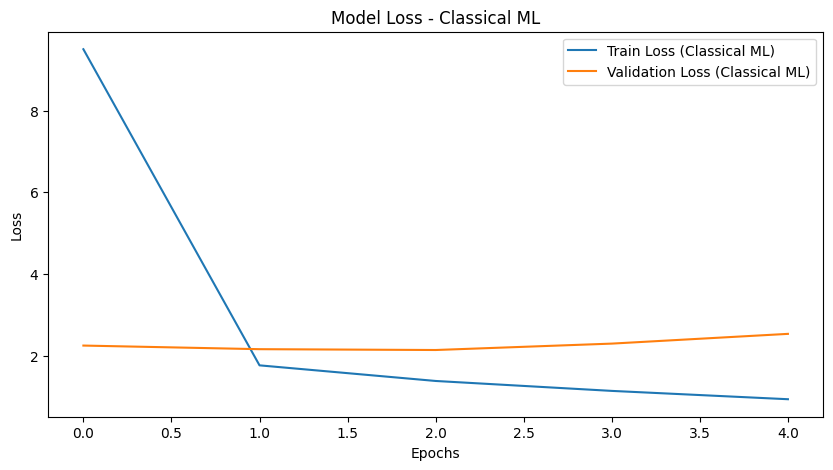

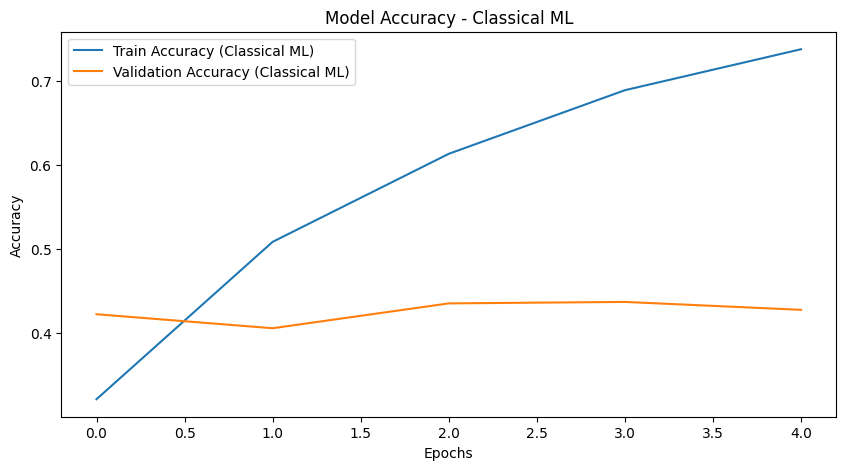

In [128]:
# Wizualizacja strat i dokładności dla modelu klasycznego
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (Classical ML)')
plt.plot(history.history['val_loss'], label='Validation Loss (Classical ML)')
plt.title('Model Loss - Classical ML')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy (Classical ML)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Classical ML)')
plt.title('Model Accuracy - Classical ML')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [146]:
# Krzywa ROC dla modeli
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Przygotowanie danych dla klasycznego ML
y_test_binarized = label_binarize(y_test.argmax(axis=1), classes=list(range(28)))
y_pred_prob_classical = model.predict(X_test)

fpr_classical, tpr_classical, _ = roc_curve(y_test_binarized.ravel(), y_pred_prob_classical.ravel())
roc_auc_classical = auc(fpr_classical, tpr_classical)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



3094/3094 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step


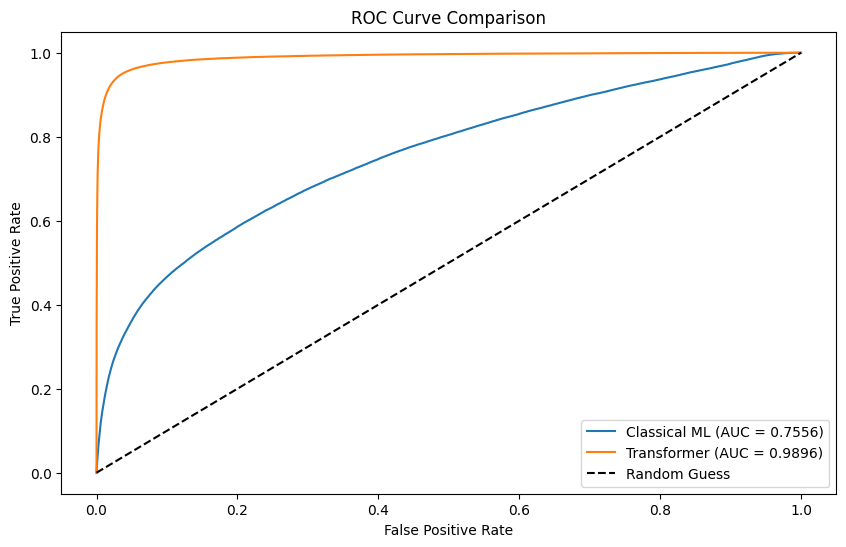

In [147]:
# Przygotowanie danych dla transformera
y_pred_prob_transformer = predictions.predictions
fpr_transformer, tpr_transformer, _ = roc_curve(y_test_binarized.ravel(), y_pred_prob_transformer.ravel())
roc_auc_transformer = auc(fpr_transformer, tpr_transformer)

plt.figure(figsize=(10, 6))
plt.plot(fpr_classical, tpr_classical, label=f'Classical ML (AUC = {roc_auc_classical:.4f})')
plt.plot(fpr_transformer, tpr_transformer, label=f'Transformer (AUC = {roc_auc_transformer:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Transformer (pomarańczowa linia):
Krzywa transformera jest znacznie bliższa lewemu górnemu rogowi wykresu.
Wartość AUC (Area Under Curve) wynosi 0.9896, co wskazuje, że model transformera jest bardzo skuteczny w rozróżnianiu klas.
Wyższe AUC oznacza lepszą zdolność modelu do prawidłowego klasyfikowania pozytywnych i negatywnych przypadków.


Classical ML (niebieska linia):
Krzywa modelu klasycznego jest niższa niż dla transformera, co oznacza, że model jest mniej skuteczny.
Wartość AUC wynosi 0.7556, co jest wyraźnie niższe niż dla transformera.
Mimo że model klasyczny działa lepiej niż losowe zgadywanie (AUC > 0.5), jego wydajność jest ograniczona w porównaniu do modelu opartego na transformatorze.

Random Guess (czarna linia przerywana):
Linia przerywana to linia losowego zgadywania, z AUC wynoszącym 0.5.
Wszystkie modele o AUC > 0.5 mają pewną zdolność do klasyfikacji lepszą niż losowe zgadywanie.
Wnioski:
Transformer jest zdecydowanie lepszym modelem: Wysoka wartość AUC (0.9896) wskazuje, że model transformera bardzo skutecznie rozróżnia klasy.
Model klasyczny ML jest wyraźnie słabszy: AUC wynoszące 0.7556 wskazuje, że model klasyczny ma ograniczoną zdolność do prawidłowego klasyfikowania, szczególnie w porównaniu do transformera.
Zastosowanie transformera jest uzasadnione, szczególnie dla problemów, gdzie wysoka dokładność klasyfikacji jest kluczowa.

In [149]:
y_true_transformer = np.array(y_true_transformer)
y_pred_transformer = np.array(y_pred_transformer)

# Analiza błędów
print("\n--- Error Analysis ---")
errors_transformer = np.sum(y_true_transformer != y_pred_transformer)
print(f"Liczba błędnych predykcji - Transformer: {errors_transformer}")

# Dla klasycznego ML
y_true = np.array(y_true)
y_pred = np.array(y_pred)

errors_classical = np.sum(y_true != y_pred)
print(f"Liczba błędnych predykcji - Classical ML: {errors_classical}")


--- Error Analysis ---
Liczba błędnych predykcji - Transformer: 14558
Liczba błędnych predykcji - Classical ML: 66986


In [153]:
# Analiza błędów - Wyświetlanie błędnych predykcji
def display_errors(df, y_true, y_pred, num_errors=5):
    errors = []
    for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
        if true_label != pred_label:
            errors.append((df.iloc[i]['hard_text'], true_label, pred_label))

    print(f"\nTop {num_errors} Errors:")
    for i, (text, true_label, pred_label) in enumerate(errors[:num_errors]):
        print(f"Error {i + 1}:")
        print(f"Text: {text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}\n")

print("\nErrors in Classical ML Model:")
display_errors(test_df, y_true, y_pred)

print("\nErrors in Transformer Model:")
display_errors(test_df, y_true_transformer, y_pred_transformer)


Errors in Classical ML Model:

Top 5 Errors:
Error 1:
Text: start dj music producer electronic music scene london mid hire composer music supervisor viacom mtv networks mtv emanuel score title song trailer program expose agency mtv movie awards mtv music video award emanuel launch online searchable music catalog urbanstylemusiccom usm usm onestopshop music website agency production company
True Label: 5
Predicted Label: 26

Error 2:
Text: averse thing scary sad grow exclusively watch sitcom romantic slapstick comedy cite simpsons big influence degree reference tattooed person begin write comedy performing standup june eventually survive cat hair stylist geoffrey
True Label: 4
Predicted Label: 1

Error 3:
Text: prior join usc mobile news editor buzzfeed news deputy mobile editor los angeles times editor yahoo news reporter associated press tag bot buzzbot buzzfeed cover convention dnc news bot rnc robots washington post comment close
True Label: 21
Predicted Label: 22

Error 4:
Text: h